In [1]:
#!pip install tensorflow

In [2]:
#!pip install Pillow

In [3]:
#!pip install scipy

In [4]:
#!pip install SimpleITK

In [5]:
#pip install imageio

In [6]:
import sys, pkgutil
print("Kernel Python:", sys.executable)



Kernel Python: C:\Users\hp\anaconda3\python.exe


In [7]:
# install GPU PyTorch (CUDA 11.8 build) 
# Cuz my GPU is NVIDIA 1050 TI
#%pip install --upgrade --index-url https://download.pytorch.org/whl/cu118 torch torchvision torchaudio

## Importing Libraries

In [8]:
import SimpleITK as sitk
import tensorflow
print(tensorflow.__version__)

2.20.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns 
import random
import os
import glob
import imageio.v2 as imageio
import multiprocessing
import ipywidgets as widgets
import torch
import torch.nn as nn
import torch.nn.functional as F

from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.display import display
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix
from tqdm import tqdm
from PIL import Image
import imageio.v2 as imageio
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

## Firstly setting up path

In [ ]:

# defining user paths
ROOT = r"..\data\Image"
meta_csv  = r"..\data\Meta\lidc_slices.csv" 
IMG_EXT_PRIORITY = [".png"]   


# global hyper params

IMG_SIZE       = 224
BATCH_SIZE     = 32
EPOCHS         = 20
LR             = 1e-4
WEIGHT_DECAY   = 1e-4
NUM_WORKERS    = 0          
PATIENCE       = 5          
VAL_SIZE       = 0.2
AUGMENT        = True
PRETRAINED     = True       
FREEZE_BACKBONE_EPOCHS = 2  

SAVE_BEST_PATH = "best_resnet18_lidc_slices.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:

def find_all_images(root_dir: str, exts):
    root = Path(root_dir)
    files = []
    for ext in exts:
        files.extend(root.rglob(f"*{ext}"))
    index = {}
    for p in files:
        key1 = p.name.lower()
        key2 = str(p).replace(str(root)+os.sep, "").replace("\\", "/").lower()
        index[key1] = p
        index[key2] = p
    return index, files

def guess_label_column(df: pd.DataFrame):
    candidates = ["label","is_cancer","target","y","cancer","class","malignant"]
    for c in candidates:
        if c in df.columns:
            return c
    # attempting 0/1 bool-like
    for c in df.columns:
        ser = df[c].dropna()
        if len(ser) and ser.isin([0,1,"0","1",True,False]).all():
            return c
    raise ValueError("Could not find a binary label column in CSV. Add one of: label, is_cancer, target, y, cancer, class, malignant")

def guess_image_key_column(df: pd.DataFrame):
    candidates = ["filename","image","img","slice_name","slice_id","path","filepath","relative_path"]
    for c in candidates:
        if c in df.columns:
            return c
    # any col containing a filename with extension
    for c in df.columns:
        col = df[c].astype(str)
        if col.str.contains(r"\.(png|jpg|jpeg|bmp|tif)$", case=False, regex=True).any():
            return c
    raise ValueError("Could not find an image name/path column in CSV. Add one of: filename, image, img, slice_name, path, filepath")

def to_int01(x):
    if isinstance(x, str):
        x = x.strip().lower()
        if x in ["1","true","yes","malignant","cancer","pos","positive"]:
            return 1
        return 0
    return int(bool(x))

class SliceDataset(Dataset):
    def __init__(self, df, train=True, img_size=224, augment=True):
        self.df = df.reset_index(drop=True)
        self.train = train
        mean = [0.485, 0.456, 0.406]
        std  = [0.229, 0.224, 0.225]
        aug = []
        if train:
            if augment:
                aug += [
                    transforms.RandomResizedCrop(img_size, scale=(0.8,1.0)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.2),
                    transforms.RandomRotation(10),
                ]
            else:
                aug += [transforms.Resize((img_size, img_size))]
        else:
            aug += [transforms.Resize((img_size, img_size))]
        self.tfms = transforms.Compose(aug + [
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = Path(row["path"])
        with Image.open(path) as im:
            im = im.convert("RGB")
        x = self.tfms(im)
        y = torch.tensor(row["label"], dtype=torch.float32)
        return x, y


In [34]:

def build_model(pretrained=True):
    # ResNet-18 binary head
    try:
        if pretrained:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            m = models.resnet18(weights=weights)
        else:
            m = models.resnet18(weights=None)
    except Exception:
        m = models.resnet18(weights=None)
    in_feats = m.fc.in_features
    m.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_feats, 1)
    )
    return m


In [ ]:
#Evaluate on ResNet
def evaluate(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb).squeeze(1)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long().cpu().numpy().tolist()
            y_pred.extend(preds)
            y_true.extend(yb.long().cpu().numpy().tolist())
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    return acc, f1

def live_plot_init():
    plt.close("all")
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)
    ax.set_title("Training progress")
    ax.set_xlabel("epoch")
    (line_loss,) = ax.plot([], [], label="train loss")
    (line_acc,)  = ax.plot([], [], label="val acc")
    (line_f1,)   = ax.plot([], [], label="val f1")
    ax.legend(loc="best")
    return fig, ax, line_loss, line_acc, line_f1

def live_plot_update(ax, line_loss, line_acc, line_f1, losses, accs, f1s):
    xs = list(range(1, len(losses)+1))
    line_loss.set_data(xs, losses)
    line_acc.set_data(xs, accs)
    line_f1.set_data(xs, f1s)
    ax.relim(); ax.autoscale_view()
    clear_output(wait=True)
    display(ax.figure)


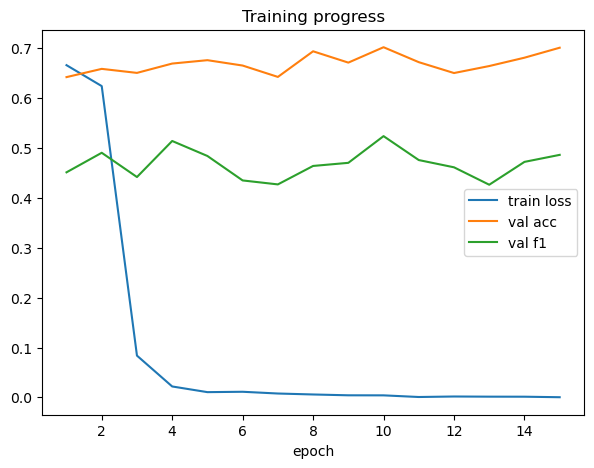

Early stopping at epoch 15 (no improvement for 5 epochs).

Best epoch = 10 | Best val accuracy = 0.7020
Best model saved to: best_resnet18_lidc_slices.pt


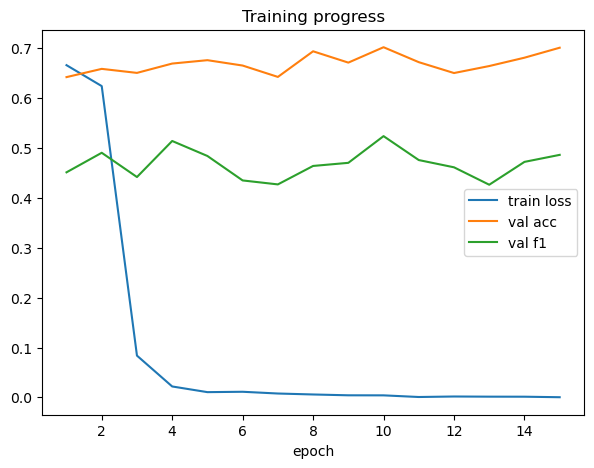

In [ ]:
index, files = find_all_images(ROOT, IMG_EXT_PRIORITY)
if not index:
    raise RuntimeError(f"No images found under {ROOT} with extensions {IMG_EXT_PRIORITY}")
print(f"Found {len(files)} image files.")

df = pd.read_csv(meta_csv)

# label column
label_col = guess_label_column(df)

#  try image column
#Found if missing then
def guess_patient_column(df: pd.DataFrame):
    cand = [
        "patient", "patient_id", "patientid", "pid",
        "seriesuid", "series_uid",
        "study", "study_id", "StudyInstanceUID",
        "lidc_id", "lidc", "LIDC_IDRI"
    ]
    for c in cand:
        if c in df.columns:
            return c
    # column that contains 'LIDC-IDRI' token
    for c in df.columns:
        if df[c].astype(str).str.contains("LIDC-IDRI", case=False, regex=False).any():
            return c
    raise ValueError(
        "No image column and no patient id column found. "
        "Add one of: patient, patient_id, patientid, pid, seriesuid, study_id, LIDC_IDRI"
    )

def norm_patient_token(x) -> str:
    """
    Normalize anything like 'LIDC-IDRI-0007', '7', 7, '0071' -> '0007' or '0071'
    We keep 4-digit zero-padded string for matching folder names.
    """
    s = str(x).strip()
    import re
    m = re.search(r"(\d{1,4})(?!.*\d)", s) 
    if m:
        n = int(m.group(1))
        return f"{n:04d}"
    m = re.search(r"(\d+)", s)
    if m:
        n = int(m.group(1))
        return f"{n:04d}"
    return None

try:
    img_col = guess_image_key_column(df)
    print("Label column:", label_col)
    print("Image column:", img_col)

    def norm_key(s: str):
        s = str(s)
        s1 = s.split("|")[-1]
        s1 = s1.replace("\\","/").lower()
        # allow filename
        return s1.split("/")[-1] if "." in Path(s1).name else s1

    paths, labels = [], []
    not_found = 0
    for _, row in df.iterrows():
        key = norm_key(row[img_col])
        p = index.get(key) or index.get(Path(key).name)
        if p is None:
            not_found += 1
            continue
        # manually skip 0071 cuz it had corrupted data
        if Path(p).parent.name.endswith("0071"):
            continue
        paths.append(str(p))
        labels.append(1 if to_int01(row[label_col])==1 else 0)

    if len(paths) == 0:
        raise RuntimeError("Matched 0 CSV rows to images. Check your CSV image column values vs filenames in the folders.")

    data = pd.DataFrame({"path": paths, "label": labels})

except ValueError:
    pat_col = guess_patient_column(df)
    print("Label column:", label_col)
    print("Using patient-level join via column:", pat_col)

    # build patient, label map
    tmp = df[[pat_col, label_col]].copy()
    tmp["pat_norm"] = tmp[pat_col].apply(norm_patient_token)
    tmp = tmp.dropna(subset=["pat_norm"])
    # mode per patient
    patient_labels = (
        tmp.groupby("pat_norm")[label_col]
           .apply(lambda s: int(round(s.map(to_int01).mean())))
           .to_dict()
    )

    paths, labels = [], []
    unmatched = 0
    used = 0
    for p in files:
        folder = p.parent.name
        pat_code = norm_patient_token(folder)  
        if pat_code is None:
            unmatched += 1
            continue
        # skip patient 0071 as requested
        if pat_code == "0071":
            continue
        lab = patient_labels.get(pat_code, None)
        if lab is None:
            unmatched += 1
            continue
        paths.append(str(p))
        labels.append(to_int01(lab))
        used += 1

    if used == 0:
        raise RuntimeError("Could not map any images to patient labels. "
                           "Ensure your CSV has a patient id column matching folder codes like 'LIDC-IDRI-0007' or numeric IDs.")
    data = pd.DataFrame({"path": paths, "label": labels})
    print(f"Mapped {used} images to patient labels; skipped {unmatched} images (no matching patient/ignored).")

# add group from folder
data["group"] = data["path"].apply(lambda s: Path(s).parent.name)
print(f"Total usable slices: {len(data)}")

#Split gropus
groups = data["group"].values
splitter = GroupShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=SEED)
train_idx, val_idx = next(splitter.split(data, groups=groups))
train_df = data.iloc[train_idx].reset_index(drop=True)
val_df   = data.iloc[val_idx].reset_index(drop=True)

def balance_summary(df, name):
    c = Counter(df["label"].tolist())
    total = len(df)
    pretty = {k: f"{v} ({v/total:.2%})" for k,v in c.items()}
    print(f"{name} size={total} | class balance: {pretty}")

balance_summary(train_df, "train")
balance_summary(val_df, "val")

#data loaders here
train_ds = SliceDataset(train_df, train=True,  img_size=IMG_SIZE, augment=AUGMENT)
val_ds   = SliceDataset(val_df,   train=False, img_size=IMG_SIZE, augment=False)

cls_counts = Counter(train_df["label"].tolist())
weights = {cls: sum(cls_counts.values())/v for cls,v in cls_counts.items()}
sample_weights = [weights[int(y)] for y in train_df["label"].tolist()]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                      num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)

#Model optimisatioon
model = build_model(pretrained=PRETRAINED).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LR*0.1)

# freeze backbone for warmup
backbone_params = [p for n,p in model.named_parameters() if not n.startswith("fc.")]
for p in backbone_params:
    p.requires_grad = False

#Training as well as live plot
fig, ax, line_loss, line_acc, line_f1 = live_plot_init()
train_losses, val_accs, val_f1s = [], [], []

best_acc = -1.0
best_epoch = 0
epochs_no_improve = 0

for ep in range(1, EPOCHS+1):
    # unfreeze backbone after warmup
    if ep == FREEZE_BACKBONE_EPOCHS + 1:
        for p in backbone_params:
            p.requires_grad = True

    model.train()
    running = 0.0; n = 0
    pbar = tqdm(train_dl, desc=f"epoch {ep}/{EPOCHS}", leave=False)
    for xb, yb in pbar:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb).squeeze(1)
        loss = criterion(logits, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        running += float(loss) * xb.size(0)
        n += xb.size(0)
        pbar.set_postfix(loss=float(loss))
    epoch_loss = running / max(n,1)
    train_losses.append(epoch_loss)

    acc, f1 = evaluate(model, val_dl, device)
    val_accs.append(acc)
    val_f1s.append(f1)

    scheduler.step()

    # Console print
    print(f"epoch {ep:02d} | train_loss {epoch_loss:.4f} | val_acc {acc:.4f} | val_f1 {f1:.4f}")

    # Live plot in notebook
    live_plot_update(ax, line_loss, line_acc, line_f1, train_losses, val_accs, val_f1s)

    # Save on checkpoints
    if acc > best_acc:
        best_acc = acc
        best_epoch = ep
        epochs_no_improve = 0
        torch.save({"model": model.state_dict(),
                    "epoch": ep,
                    "val_acc": float(best_acc),
                    "config": {
                        "IMG_SIZE": IMG_SIZE,
                        "BATCH_SIZE": BATCH_SIZE,
                        "LR": LR,
                        "AUGMENT": AUGMENT
                    }}, SAVE_BEST_PATH)
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {ep} (no improvement for {PATIENCE} epochs).")
        break

print(f"\nBest epoch = {best_epoch} | Best val accuracy = {best_acc:.4f}")
print(f"Best model saved to: {SAVE_BEST_PATH}")


## Training and Testing (80-20)

=== Final Evaluation on Validation Set ===
Accuracy : 0.7020
Precision: 0.7617
Recall   : 0.3991
F1-Score : 0.5238
AUC (ROC): 0.6894

Classification Report:
               precision    recall  f1-score   support

           0     0.6857    0.9130    0.7832      5921
           1     0.7617    0.3991    0.5238      4124

    accuracy                         0.7020     10045
   macro avg     0.7237    0.6561    0.6535     10045
weighted avg     0.7169    0.7020    0.6767     10045



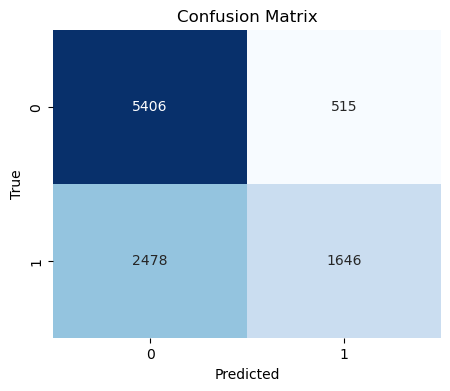

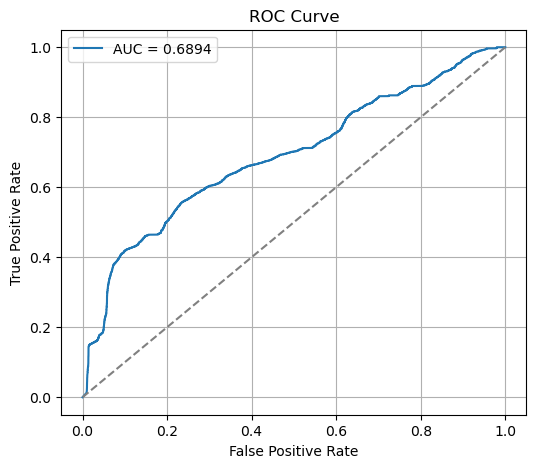

In [38]:
#Eva metrics
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score, classification_report
)
import seaborn as sns

# Load the best saved model
ckpt = torch.load(SAVE_BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

y_true, y_prob, y_pred = [], [], []
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        logits = model(xb).squeeze(1)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        y_prob.extend(probs.tolist())
        y_pred.extend(preds.tolist())
        y_true.extend(yb.cpu().numpy().astype(int).tolist())

# convert to numpy arrays
import numpy as np
y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

# metrics
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)
auc  = roc_auc_score(y_true, y_prob)

print("=== Final Evaluation on Validation Set ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC (ROC): {auc:.4f}\n")
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
fpr, tpr, thr = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
